In [1]:
from scripts.analyze_embeddings import *
import os
import pickle
import torch as t
from model import Word2Vec, SGNS
import math
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Load BOTH input and output embeddings
idx2ivec_path = "runs/R512-train-window-10/idx2ivec.dat"
idx2ovec_path = "runs/R512-train-window-10/idx2ovec.dat"

idx2ivec = pickle.load(open(idx2ivec_path, 'rb'))
idx2ovec = pickle.load(open(idx2ovec_path, 'rb'))

print(f"Loaded idx2ivec (input vectors) with {len(idx2ivec)} embeddings")
print(f"Loaded idx2ovec (output vectors) with {len(idx2ovec)} embeddings")
print(f"Embedding dimension: {idx2ivec[0].shape if len(idx2ivec) > 0 else 'N/A'}")

# Note: idx2ivec and idx2ovec are indexed by word index
# We'll create word2embed dicts after loading idx2word

Loaded idx2vec with 50304 embeddings
Embedding dimension: (512,)


In [ ]:
# Configuration
data_dir = "/cache/openwebtext/train"  # Update this to your data directory
model_path = "runs/R512-train-window-10/sgns.pt"  # Update to your model path
e_dim = 512  # Embedding dimension

# Load vocab
words = pickle.load(open(os.path.join(data_dir, 'idx2word.dat'), 'rb'))
vocab_size = len(words)
print(f"Vocab size: {vocab_size}")
print(words)

# Create word-to-embedding dictionaries for BOTH input and output vectors
ivec_embeds = {words[idx]: idx2ivec[idx] for idx in range(len(words))}
ovec_embeds = {words[idx]: idx2ovec[idx] for idx in range(len(words))}
print(f"Created ivec_embeds dict with {len(ivec_embeds)} entries")
print(f"Created ovec_embeds dict with {len(ovec_embeds)} entries")

Vocab size: 50304
['<UNK>', 'the', 'to', 'of', 'and', 'a', 'in', 'that', 'is', 'for', 'on', 'with', 'was', 'The', 'as', 'it', 'be', 'are', 'I', 'have', 'at', 'by', 'from', 'this', 'you', 'not', 'an', 'he', 'has', 'his', 'or', 'but', 'will', 'they', 'their', 'we', 'more', 'who', 'about', 'can', 'were', 'had', 'which', 'been', 'would', 'one', 'all', 'said', 'out', 'up', 'also', 'when', 'In', 'than', 'its', 'your', 'like', 'what', 'if', 'into', 'so', 'just', 'other', 'some', 'people', 'our', 'her', 'my', 'do', 'no', 'only', 'new', 'there', 'It', 'after', 'first', 'could', 'over', 'But', 'This', '–', 'get', 'two', 'she', 'how', 'He', 'time', '—', 'because', 'them', 'most', 'any', 'A', 'even', 'these', 'make', '-', 'being', 'where', 'many', 'And', 'those', 'very', 'last', 'him', 'said.', 'then', 'much', 'should', 'now', 'may', 'such', 'see', 'through', 'made', 'back', 'going', 'against', 'think', 'We', 'way', 'before', 'me', 'If', 'still', 'use', 'while', 'years', 'between', 'know', 'want',

In [4]:
# Load model to get coord_weights
print(f"Loading model from {model_path}...")
model = Word2Vec(vocab_size=vocab_size, embedding_size=e_dim, torus=False)
sgns = SGNS(embedding=model, vocab_size=vocab_size, n_negs=20, torus=False)
sgns.load_state_dict(t.load(model_path, map_location='cpu'))

Loading model from runs/R512-train-window-10/sgns.pt...


<All keys matched successfully>

In [ ]:
# Summary
print(f"\nSummary:")
print(f"  Loaded {len(idx2ivec)} input vectors from idx2ivec.dat")
print(f"  Loaded {len(idx2ovec)} output vectors from idx2ovec.dat")
print(f"  Created word-to-embedding dicts with {len(ivec_embeds)} entries each")
print(f"  Embedding dimension: {len(list(ivec_embeds.values())[0])}")
print(f"  Vocab size: {vocab_size}")


Summary:
  Loaded 50304 embeddings from idx2vec.dat
  Created word-to-embedding dict with 50304 entries
  Embedding dimension: 512
  Vocab size: 50304


In [ ]:
man_ivec = ivec_embeds['man']
man_ovec = ovec_embeds['man']
print(f"Input vector range: {min(man_ivec):.4f} to {max(man_ivec):.4f}")
print(f"Output vector range: {min(man_ovec):.4f} to {max(man_ovec):.4f}")

(np.float32(-1.1815476), np.float32(0.8176577))

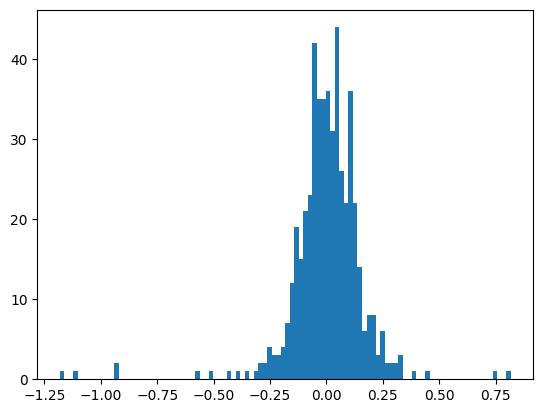

In [ ]:
# histogram of man input vector
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(man_ivec, bins=100)
plt.title('Input Vector (man)')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(man_ovec, bins=100)
plt.title('Output Vector (man)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
print(f"Input embeddings: {len(ivec_embeds)}")
print(f"Output embeddings: {len(ovec_embeds)}")

50304

In [ ]:
def dot(
    x: t.Tensor,  # [E]
    y: t.Tensor,  # [E]
) -> t.Tensor:
    x = t.tensor(x)
    y = t.tensor(y)
    # dot product
    # print(x @ y)
    return x @ y

def similarity(word1, word2):
    """
    Compute proper skip-gram similarity between two words:
    similarity(w1, w2) = dot(ivec[w1], ovec[w2])
    
    This is the correct way to measure similarity in skip-gram,
    matching the training objective.
    """
    return dot(ivec_embeds[word1], ovec_embeds[word2]).item()

In [ ]:
def get_closest_words(word, n=10):
    """
    Find closest words using proper skip-gram similarity:
    similarity(query, candidate) = dot(ivec[query], ovec[candidate])
    
    This matches the training objective where we predict context (output) 
    words given center (input) word.
    """
    query_ivec = ivec_embeds[word]
    sim = []
    for candidate_word in ovec_embeds:
        # Proper similarity: input vector of query × output vector of candidate
        h = dot(query_ivec, ovec_embeds[candidate_word]).item()
        sim.append((h, candidate_word))
    sim = sorted(sim, reverse=True)
    return sim[:n]

In [11]:
print(f"get_closest_words('man', 10): {get_closest_words('man', 10)}")
print(f"get_closest_words('woman', 10): {get_closest_words('woman', 10)}")
print(f"get_closest_words('king', 10): {get_closest_words('king', 10)}")
print(f"get_closest_words('queen', 10): {get_closest_words('queen', 10)}")

get_closest_words('man', 10): [(16.216217041015625, 'PT...'), (13.243767738342285, 'man'), (12.886689186096191, '€6.99'), (12.503541946411133, 're-enter.'), (12.478489875793457, 'tag.Click'), (12.196065902709961, 'australia'), (11.97461986541748, '[Permalink]'), (11.850162506103516, '(SOUNDBITE'), (11.831997871398926, '£5.99'), (11.721242904663086, 'ja')]
get_closest_words('woman', 10): [(14.227729797363281, 'woman'), (14.129173278808594, '$16.99/month'), (14.041543960571289, "handed'"), (13.841602325439453, 'PT...'), (12.740062713623047, 're-enter.'), (12.64088249206543, '€6.99'), (11.965581893920898, 'Noticed'), (11.903990745544434, 'woman,'), (11.868697166442871, "expect'"), (11.737190246582031, 'australia')]


get_closest_words('king', 10): [(21.74970245361328, 'king'), (14.8729248046875, "'Damn"), (14.810476303100586, '(Set1'), (14.26437759399414, '27¢'), (14.242344856262207, 'throne'), (14.185483932495117, 'throne,'), (14.046406745910645, 'Noticed'), (13.260360717773438, 'Rt'), (12.969743728637695, '(c.'), (12.756731033325195, "'fair")]
get_closest_words('queen', 10): [(34.76954650878906, 'queen'), (21.877368927001953, 'Noticed'), (18.63605499267578, 'queen,'), (16.789072036743164, 'queens'), (16.445690155029297, '$5.99/month'), (15.76977252960205, '[Permalink]'), (15.710009574890137, 'window)'), (15.336238861083984, 'Firstpost.com/Whatsapp'), (15.005104064941406, 'orc'), (14.852457046508789, '(Opens')]


## IMPORTANT: Skip-Gram uses TWO sets of vectors!

**Input vectors (ivec)**: Used for center words
**Output vectors (ovec)**: Used for context words

**Proper similarity**: `similarity(w1, w2) = dot(ivec[w1], ovec[w2])`

This is how skip-gram training works:
- Given center word w, predict context word c
- Score = dot(ivec[w], ovec[c])

**Use the `similarity(w1, w2)` function** for correct results!

Old code using `dot(embeds[w1], embeds[w2])` was WRONG - it only used input vectors.


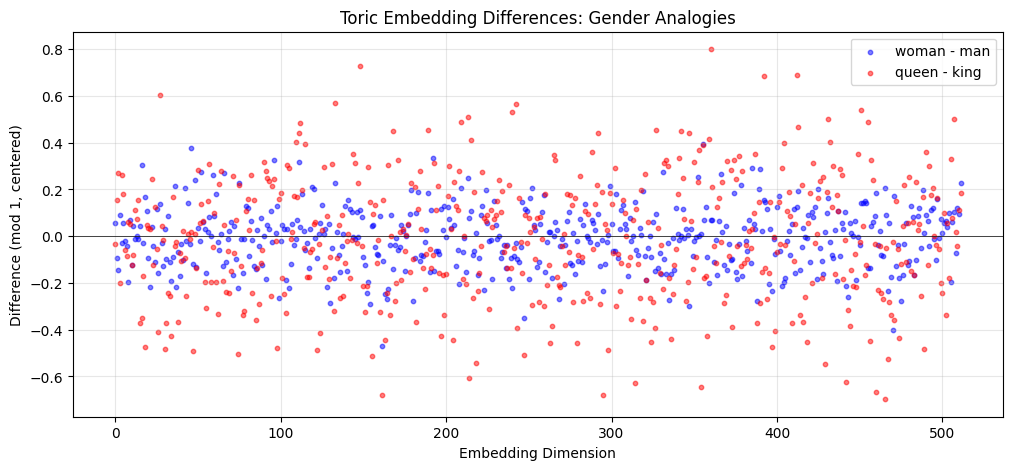

In [12]:
man_to_woman = embeds['woman'] - embeds['man']

king_to_queen = embeds['queen'] - embeds['king']


x_coords = np.arange(len(man_to_woman))

plt.figure(figsize=(12, 5))
plt.scatter(x_coords, man_to_woman, alpha=0.5, s=10, label='woman - man', color='blue')
plt.scatter(x_coords, king_to_queen, alpha=0.5, s=10, label='queen - king', color='red')
plt.xlabel('Embedding Dimension')
plt.ylabel('Difference (mod 1, centered)')
plt.title('Toric Embedding Differences: Gender Analogies')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
plt.show()


In [13]:
print(f"man_to_woman: {dot(embeds['man'], embeds['woman'])}")
print(f"king_to_queen: {dot(embeds['king'], embeds['queen'])}")
print(f"man_to_king: {dot(embeds['man'], embeds['king'])}")
print(f"woman_to_queen: {dot(embeds['woman'], embeds['queen'])}")
# man to uncle
print(f"man_to_uncle: {dot(embeds['man'], embeds['uncle'])}")
# woman to aunt
print(f"woman_to_aunt: {dot(embeds['woman'], embeds['aunt'])}")

# man to father
print(f"man_to_father: {dot(embeds['man'], embeds['father'])}")
# woman to mother
print(f"woman_to_mother: {dot(embeds['woman'], embeds['mother'])}")

# man to dad
print(f"man_to_dad: {dot(embeds['man'], embeds['dad'])}")
# woman to mom
print(f"woman_to_mom: {dot(embeds['woman'], embeds['mom'])}")

# man to son
print(f"man_to_son: {dot(embeds['man'], embeds['son'])}")
# woman to daughter
print(f"woman_to_daughter: {dot(embeds['woman'], embeds['daughter'])}")

# man to brother
print(f"man_to_brother: {dot(embeds['man'], embeds['brother'])}")
# woman to sister
print(f"woman_to_sister: {dot(embeds['woman'], embeds['sister'])}")


man_to_woman: 9.383979797363281
king_to_queen: 10.769577980041504
man_to_king: 6.9409098625183105
woman_to_queen: 8.01130485534668
man_to_uncle: 7.341602325439453
woman_to_aunt: 8.76923656463623
man_to_father: 6.523408889770508
woman_to_mother: 8.272706985473633
man_to_dad: 6.609379768371582
woman_to_mom: 6.6859283447265625
man_to_son: 7.000381946563721
woman_to_daughter: 8.000529289245605
man_to_brother: 6.133518218994141
woman_to_sister: 6.2669477462768555


In [14]:
print(f"man_to_woman: {dot(embeds['man'], embeds['woman'])}")
print(f"king_to_queen: {dot(embeds['king'], embeds['queen'])}")
print(f"dad_to_mom: {dot(embeds['dad'], embeds['mom'])}")
print(f"son_to_daughter: {dot(embeds['son'], embeds['daughter'])}")
print(f"brother_to_sister: {dot(embeds['brother'], embeds['sister'])}")
print(f"boy_to_girl: {dot(embeds['boy'], embeds['girl'])}")
print(f"boyfriend_to_girlfriend: {dot(embeds['boyfriend'], embeds['girlfriend'])}")
print(f"husband_to_wife: {dot(embeds['husband'], embeds['wife'])}")

man_to_woman: 9.383979797363281
king_to_queen: 10.769577980041504
dad_to_mom: 11.779000282287598
son_to_daughter: 10.76635456085205
brother_to_sister: 11.005736351013184
boy_to_girl: 11.520700454711914
boyfriend_to_girlfriend: 13.386510848999023
husband_to_wife: 10.328271865844727


In [15]:
sim = [(dot(embeds[word], embeds['the']), word) for word in embeds]
sim = sorted(sim, key=lambda x: x[0], reverse=True)
sim[:30]

[(tensor(10.4588), '$16.99/month'),
 (tensor(10.2452), '[Permalink]'),
 (tensor(9.9653), 'tag.Click'),
 (tensor(8.8430), 'Advertisement:'),
 (tensor(8.8232), '27¢'),
 (tensor(8.6424), 'pg,'),
 (tensor(8.6421), 'cume:'),
 (tensor(8.5643), 'PT...'),
 (tensor(8.4533), '-110'),
 (tensor(8.4404), '$5.99/month'),
 (tensor(8.4038), '$10.99/month'),
 (tensor(8.3662), 'Trump-Kim'),
 (tensor(8.3490), 'NEWSLETTERS'),
 (tensor(8.3160), '(Set1'),
 (tensor(8.2958), '*Introductory'),
 (tensor(8.0469), '$13.99/month'),
 (tensor(7.8902), 'Merit:'),
 (tensor(7.7698), 'probe:'),
 (tensor(7.7084), 'Delivery:'),
 (tensor(7.6052), 'Firstpost.com/Whatsapp'),
 (tensor(7.6049), '$0.99/month'),
 (tensor(7.5910), "expect'"),
 (tensor(7.5787), 're-enter.'),
 (tensor(7.4132), 'COMMENT'),
 (tensor(7.3437), 'что'),
 (tensor(7.2786), 'subscribing.'),
 (tensor(7.1524), "handed'"),
 (tensor(7.1133), 'window._taboola'),
 (tensor(7.0980), 'Pubmed'),
 (tensor(7.0075), '00000000')]

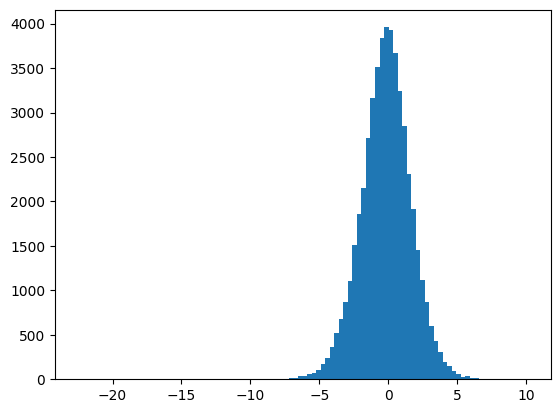

In [16]:
diffs = []
for word, embed in embeds.items():
    k_q = dot(embed, embeds['king']) - dot(embed, embeds['queen'])
    m_w = dot(embed, embeds['man']) - dot(embed, embeds['woman'])
    diffs.append((k_q-m_w).item())
plt.hist(diffs, bins=100)
plt.show()

Check log h ~ PMI

In [ ]:
# Compute e^(ln k + PMI(c,w)) vs. h(w,c) for skip-gram pairs
# where PMI(w,c) = log p(c,w)/(p_c * p_w)
# and h(w,c) is the toric similarity

# Load word counts to get marginal probabilities
wc_path = os.path.join(data_dir, 'wc.dat')
wc = pickle.load(open(wc_path, 'rb'))

# Compute total word count
total_words = sum(wc.values())
print(f"Total word count: {total_words:,}")

# Load training data to get co-occurrence counts
train_path = os.path.join(data_dir, 'train.dat')
print(f"Loading training pairs from {train_path}...")
train_data = pickle.load(open(train_path, 'rb'))
print(f"Loaded {len(train_data):,} skip-gram pairs")

Total word count: 6,548,285,048
Loading training pairs from /cache/openwebtext/train/train.dat...


In [ ]:
# Sample pairs to make computation tractable
sample_size = min(1000000, len(train_data))
import random
random.seed(42)
sampled_indices = random.sample(range(len(train_data)), sample_size)
print(f"Using {sample_size:,} sampled pairs for analysis")

Using 1,000,000 sampled pairs for analysis


In [ ]:
# The pairs are already in train.dat - each occurrence represents a co-occurrence
# For PMI estimation, we'll use the full train_data length for normalization
from collections import Counter

# Count occurrences in our sample for validation
sample_pair_counts = Counter()
sample_center_counts = Counter()
sample_context_counts = Counter()
for data_idx in sampled_indices:
    center_idx, context_indices = train_data[data_idx]
    sample_center_counts[center_idx] += 1
    for context_idx in context_indices:
        sample_pair_counts[(center_idx, context_idx)] += 1
        sample_context_counts[context_idx] += 1

print(f"Sampled {len(sample_pair_counts):,} unique pairs")

# Total pairs in full dataset (each entry in train_data has multiple contexts)
# Estimate by counting contexts in a sample
sample_contexts = [len(train_data[i][1]) for i in sampled_indices[:1000]]
avg_contexts = np.mean(sample_contexts)
total_pairs_in_data = len(train_data) * avg_contexts
print(f"Estimated total co-occurrence pairs in train.dat: {total_pairs_in_data:,.0f}")
print(f"Average contexts per center word: {avg_contexts:.2f}")

Sampled 3,488,208 unique pairs
Estimated total co-occurrence pairs in train.dat: 8,294,844,990
Average contexts per center word: 10.00


In [ ]:
sample_pair_counts

Counter({(0, 0): 255434,
         (1, 0): 62549,
         (0, 1): 39182,
         (3, 0): 32527,
         (4, 0): 30349,
         (2, 0): 28466,
         (5, 0): 26911,
         (0, 4): 22390,
         (6, 0): 21600,
         (0, 3): 21194,
         (1, 3): 20554,
         (3, 1): 20340,
         (1, 1): 19740,
         (0, 2): 18131,
         (13, 0): 17737,
         (0, 5): 17538,
         (8, 0): 14545,
         (0, 6): 13702,
         (2, 1): 13548,
         (1, 2): 13384,
         (1, 4): 11492,
         (4, 1): 11369,
         (9, 0): 10828,
         (1, 6): 10718,
         (6, 1): 10535,
         (7, 0): 10081,
         (10, 0): 9742,
         (0, 8): 8544,
         (12, 0): 8466,
         (11, 0): 8327,
         (0, 7): 7121,
         (0, 9): 6979,
         (14, 0): 6875,
         (5, 1): 6476,
         (5, 3): 6448,
         (3, 5): 6421,
         (1, 5): 6414,
         (21, 0): 6127,
         (0, 11): 6005,
         (17, 0): 5945,
         (3, 4): 5893,
         (4, 3): 5846,

In [ ]:
# Compute PMI and toric similarity for sampled pairs
k = 20  # Number of negative samples in SGNS

i_values = []  # PMI(c,w)
sim_values = []   # h(w,c)
pair_words = []

total_centers = sum(sample_center_counts.values())
assert total_centers == sample_size
total_contexts = sum(sample_context_counts.values())
assert total_contexts == 10 * sample_size

print("Computing PMI and toric similarities for unique pairs...")
unique_pairs = list(sample_pair_counts.items())
for idx_num, ((center_idx, context_idx), count_pair) in enumerate(unique_pairs):
    if idx_num % 10000 == 0:
        print(f"  Processed {idx_num:,}/{len(unique_pairs):,} unique pairs", end='\r')
    
    center_word = words[center_idx]
    context_word = words[context_idx]
    
    # Get counts
    count_w = sample_center_counts[center_idx]
    count_c = sample_context_counts[context_idx]
    
    # Compute probabilities
    p_c = count_c / total_contexts
    p_c_given_w = count_pair / (10 * count_w)
    
    # Compute PMI: log(p(w,c)/(p_w * p_c))
    pmi = math.log(p_c_given_w / p_c + 1e-10)
    
    
    # Compute toric similarity h(w,c)
    if center_word in embeds and context_word in embeds:
        h_wc = dot(embeds[center_word], embeds[context_word]).item()
        
        i_values.append(pmi)
        sim_values.append(h_wc)
        pair_words.append((center_word, context_word))

print(f"\nComputed {len(i_values):,} valid pairs")

pmi_values = np.array(i_values)
sim_values = np.array(sim_values)

Computing PMI and toric similarities for unique pairs...
  Processed 3,480,000/3,488,208 unique pairs
Computed 3,488,208 valid pairs


Correlation: 0.2982


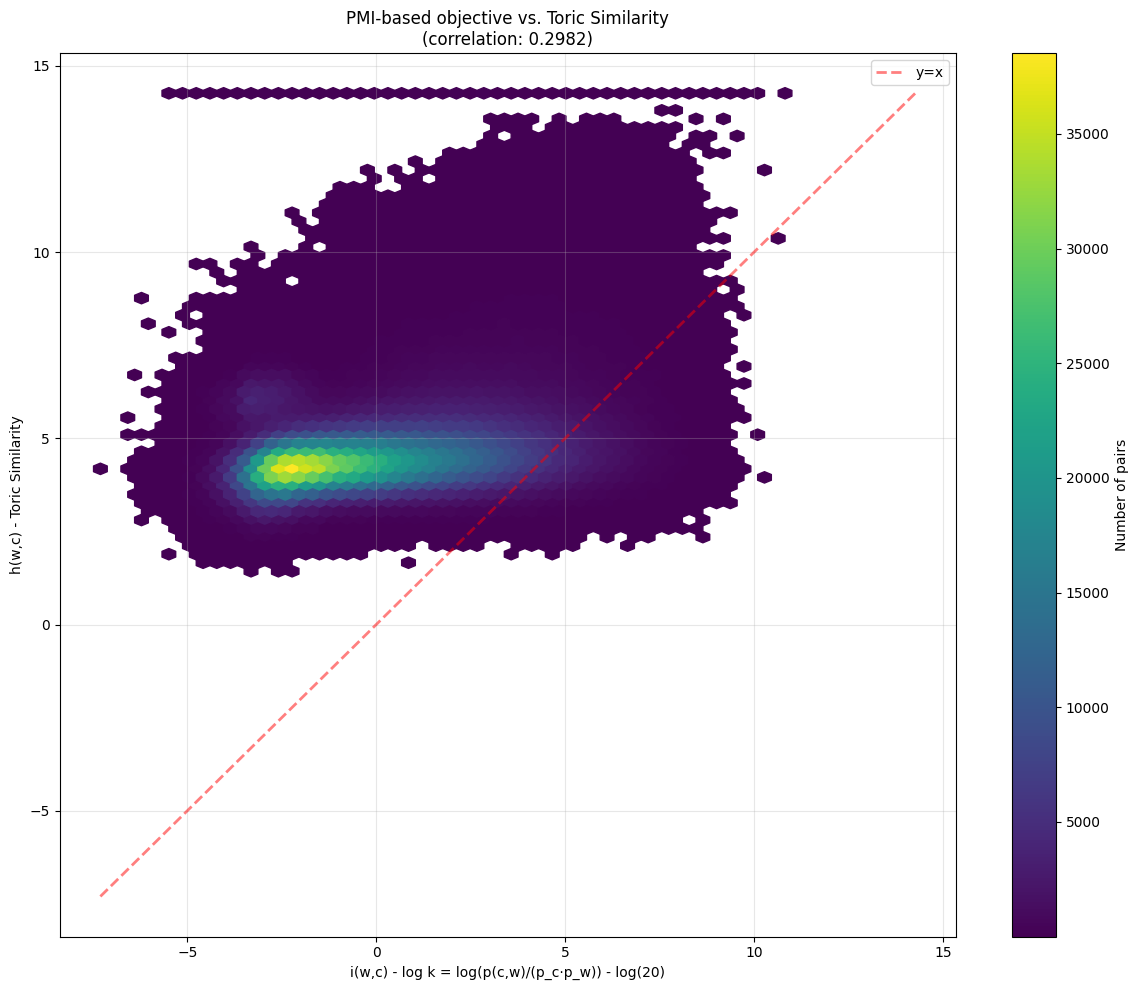


Statistics:
  PMI - log k: mean=0.0303, std=2.5404
  h(w,c): mean=4.5474, std=0.9349
  Pearson correlation: 0.2982

Top 5 pairs by PMI - log k:
  (├──, ├──): PMI-log k=10.8198, h(w,c)=14.2646
  (largeDownload, FIGURE): PMI-log k=10.8198, h(w,c)=10.2946
  (├──, │): PMI-log k=10.1266, h(w,c)=12.1194
  (crux, matter:): PMI-log k=10.1266, h(w,c)=5.0797
  (dwellers, Ebola.): PMI-log k=10.1266, h(w,c)=3.8665

Top 5 pairs by toric similarity:
  (Array, Array): PMI-log k=5.7699, h(w,c)=14.2646
  (obviously, obviously): PMI-log k=0.8212, h(w,c)=14.2646
  (sand, sand): PMI-log k=3.2936, h(w,c)=14.2646
  (Defence, Defence): PMI-log k=4.3965, h(w,c)=14.2646
  (Cowboys, Cowboys): PMI-log k=3.6597, h(w,c)=14.2646


In [ ]:
# Convert e^(ln k + PMI) to PMI - ln k for comparison
# pmi_based_values currently stores e^(ln k + PMI)
# We want: PMI - ln k = log(p(c,w)/(p_c*p_w)) - log k
k = 20
i_minus_logk = i_values - np.log(k)

# Plot PMI - log k vs. h(w,c)
plt.figure(figsize=(12, 10))

# Create 2D histogram / hexbin plot for better visualization with many points
plt.hexbin(i_minus_logk, sim_values, gridsize=50, cmap='viridis', mincnt=1)
plt.colorbar(label='Number of pairs')

# Compute correlation
correlation = np.corrcoef(i_minus_logk, sim_values)[0, 1]
print(f"Correlation: {correlation:.4f}")

# Add reference line for perfect correlation
min_val = min(i_minus_logk.min(), sim_values.min())
max_val = max(i_minus_logk.max(), sim_values.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.5, label='y=x')

plt.xlabel('i(w,c) - log k = log(p(c,w)/(p_c·p_w)) - log(20)')
plt.ylabel('h(w,c) - Dot Product')
plt.title(f'PMI-based objective vs. Dot Product\n(correlation: {correlation:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print statistics
print(f"\nStatistics:")
print(f"  PMI - log k: mean={i_minus_logk.mean():.4f}, std={i_minus_logk.std():.4f}")
print(f"  h(w,c): mean={sim_values.mean():.4f}, std={sim_values.std():.4f}")
print(f"  Pearson correlation: {correlation:.4f}")

# Show some example pairs with high and low values
print(f"\nTop 5 pairs by PMI - log k:")
top_pmi_idx = np.argsort(i_minus_logk)[-5:][::-1]
for idx in top_pmi_idx:
    w, c = pair_words[idx]
    print(f"  ({w}, {c}): PMI-log k={i_minus_logk[idx]:.4f}, h(w,c)={sim_values[idx]:.4f}")

print(f"\nTop 5 pairs by dot product:")
top_h_idx = np.argsort(sim_values)[-5:][::-1]
for idx in top_h_idx:
    w, c = pair_words[idx]
    print(f"  ({w}, {c}): PMI-log k={i_minus_logk[idx]:.4f}, h(w,c)={sim_values[idx]:.4f}")


In [ ]:
# Compute gender direction differences and plot correlation
def check_correlation(
    man="man",
    woman="woman",
    king="king",
    queen="queen",
    interesting_words = ['man', 'woman', 'king', 'queen', 'boy', 'girl', 'he', 'she', 
                        'father', 'mother', 'son', 'daughter', 'brother', 'sister']
):
    k_q_vals = []  # king - queen direction
    m_w_vals = []  # man - woman direction
    words_list = []

    for word, embed in embeds.items():
        k_q = sum_cosine_diff(embed, embeds[king]).item() - sum_cosine_diff(embed, embeds[queen]).item()
        m_w = sum_cosine_diff(embed, embeds[man]).item() - sum_cosine_diff(embed, embeds[woman]).item()
        k_q_vals.append(k_q)
        m_w_vals.append(m_w)
        words_list.append(word)

    k_q_vals = np.array(k_q_vals)
    m_w_vals = np.array(m_w_vals)

    # Compute correlation
    correlation = np.corrcoef(k_q_vals, m_w_vals)[0, 1]
    print(f"Correlation between ({king}-{queen}) and ({man}-{woman}) directions: {correlation:.4f}")

    # Create scatter plot
    plt.figure(figsize=(12, 10))
    plt.scatter(k_q_vals, m_w_vals, alpha=0.3, s=5)

    # Add reference line y=x
    min_val = min(k_q_vals.min(), m_w_vals.min())
    max_val = max(k_q_vals.max(), m_w_vals.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='y=x (perfect correlation)')

    # Annotate some interesting words
    
    for word in interesting_words:
        if word in embeds:
            idx = words_list.index(word)
            plt.annotate(word, (k_q_vals[idx], m_w_vals[idx]), 
                        fontsize=10, alpha=0.8, 
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

    plt.xlabel(f'sim(word, {king}) - sim(word, {queen})')
    plt.ylabel(f'sim(word, {man}) - sim(word, {woman})')
    plt.title(f'Gender Direction Correlation (r={correlation:.4f})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()

    print(f"\nWords most aligned with both gender directions (high {king}-{queen} and {man}-{woman}):")
    combined = k_q_vals + m_w_vals
    top_idx = np.argsort(combined)[-10:][::-1]
    for idx in top_idx:
        print(f"  {words_list[idx]}: {king}-{queen}={k_q_vals[idx]:.3f}, {man}-{woman}={m_w_vals[idx]:.3f}")


Correlation between (king-queen) and (man-woman) directions: 0.2717


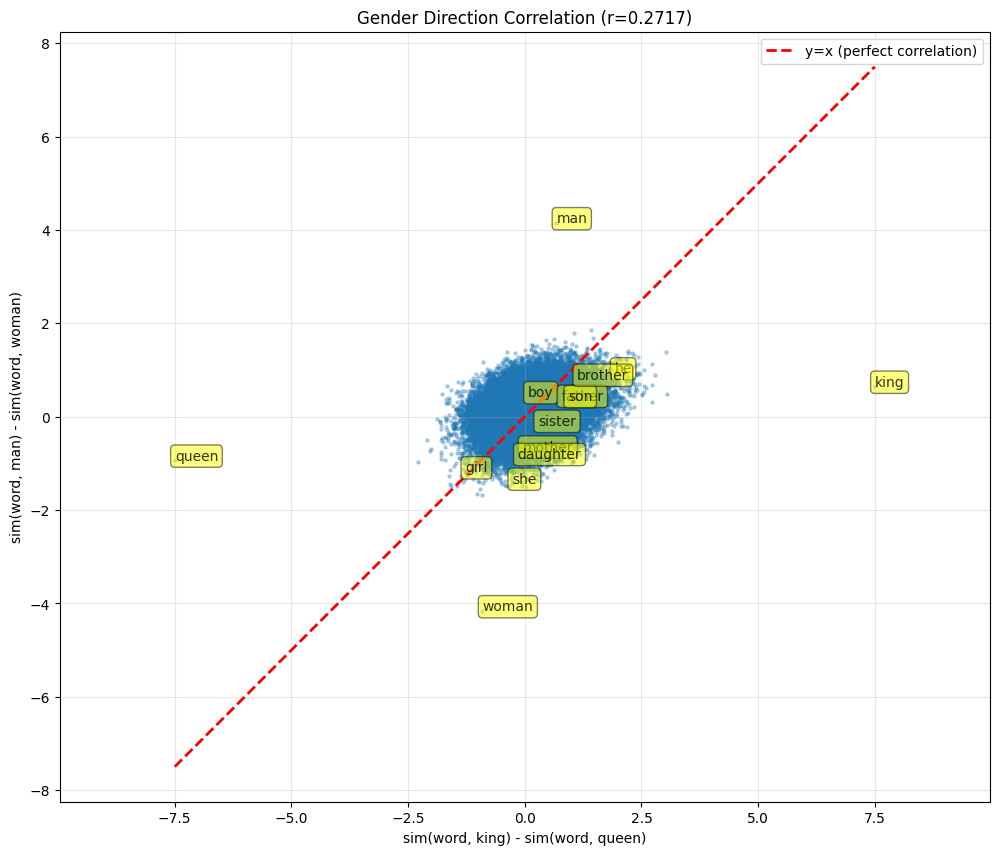


Words most aligned with both gender directions (high king-queen and man-woman):
  king: king-queen=7.499, man-woman=0.653
  man: king-queen=0.676, man-woman=4.157
  Umar: king-queen=3.020, man-woman=1.386
  Bin: king-queen=2.724, man-woman=1.124
  commanded: king-queen=2.420, man-woman=1.280
  Lord: king-queen=2.788, man-woman=0.887
  Ferdinand: king-queen=2.346, man-woman=1.315
  confrontation,: king-queen=2.287, man-woman=1.374
  Moses: king-queen=2.205, man-woman=1.398
  prophet: king-queen=2.202, man-woman=1.373


In [ ]:
check_correlation()

Correlation between (dad-mom) and (man-woman) directions: 0.1398


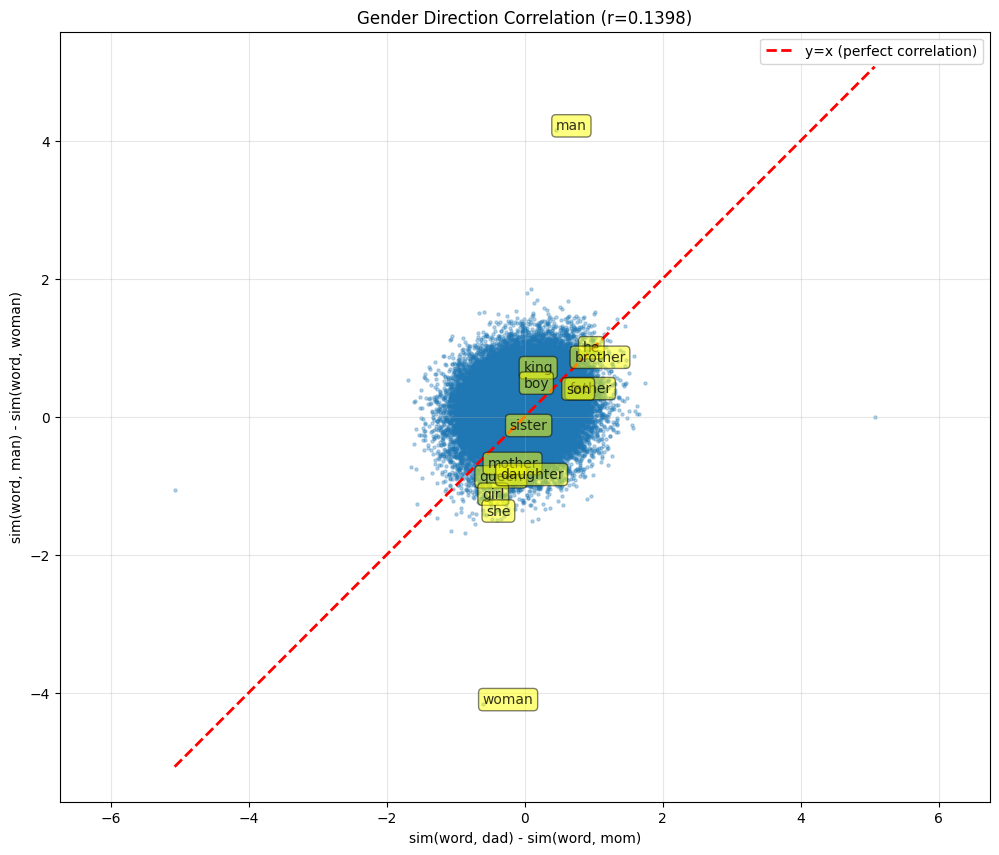


Words most aligned with both gender directions (high dad-mom and man-woman):
  dad: dad-mom=5.072, man-woman=0.000
  man: dad-mom=0.454, man-woman=4.157
  Munich: dad-mom=1.457, man-woman=1.318
  Dorsey: dad-mom=1.339, man-woman=1.420
  Kidd: dad-mom=1.013, man-woman=1.512
  Moyes: dad-mom=1.212, man-woman=1.280
  Anfield: dad-mom=1.001, man-woman=1.485
  Erich: dad-mom=1.589, man-woman=0.875
  Middlesbrough: dad-mom=1.431, man-woman=0.938
  Salah: dad-mom=1.376, man-woman=0.972


In [ ]:
check_correlation(
    man="man",
    woman="woman",
    king="dad",
    queen="mom",
    interesting_words = ['man', 'woman', 'king', 'queen', 'boy', 'girl', 'he', 'she', 
                        'father', 'mother', 'son', 'daughter', 'brother', 'sister']
)